In [1034]:
from azure.identity import DefaultAzureCredential
from azure.storage.filedatalake import DataLakeServiceClient
import io
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import itertools
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [609]:
%run ./AzureKeyVault.ipynb

In [610]:
adls_url = KeyVault().get_secret("ADLSAccountURL")
adls_container = KeyVault().get_secret("ADLSContainerName")
adls_access_key = KeyVault().get_secret("ADLSKey")

credential = DefaultAzureCredential()
service_client = DataLakeServiceClient(account_url=adls_url, credential=credential)
file_system_client = service_client.get_file_system_client(adls_container)

# functions to grab the ADLS traffic data with stations data
def get_traffic_data(file_name):
    file_client = file_system_client.get_file_client(f"fhwa/jan_2023/{file_name}")
    raw_data = file_client.download_file().readall()
    file_content_str = raw_data.decode("utf-8")
    file_like = io.StringIO(file_content_str)
    return pd.read_csv(file_like, sep='|')

def get_station_data(file_name):
    file_client = file_system_client.get_file_client(f"fhwa/station_2023/{file_name}")
    raw_data = file_client.download_file().readall()
    file_content_str = raw_data.decode("utf-8")
    file_like = io.StringIO(file_content_str)
    return pd.read_csv(file_like, sep='|')

## Returned data

#### Traffic volume data for Jan 2023 in Texas:

In [613]:
df = get_traffic_data("TX_JAN_2023 (TMAS).VOL")
df.head()

,record_type,state_code,f_system,station_id,travel_dir,travel_lane,year_record,month_record,day_record,day_of_week,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,restrictions
0,V,48,1U,000004,1,0,2023,1,1,1,...,4740,4821,4311,4200,3564,2839,2556,1968,1387,NaN
1,V,48,1U,000004,1,0,2023,1,2,2,...,4221,4756,4311,4078,2757,2862,2483,1924,1374,NaN
2,V,48,1U,000004,1,0,2023,1,3,3,...,4168,4021,4295,3891,3129,2524,2177,1735,1323,NaN
3,V,48,1U,000004,1,0,2023,1,4,4,...,4039,3821,4182,3753,3210,2401,1956,1563,1127,NaN
4,V,48,1U,000004,1,0,2023,1,5,5,...,4057,4049,4274,3871,3101,2513,1971,1668,1191,NaN


#### Traffic station data for all of 2023 in Texas

In [615]:
station_df = get_station_data("TX_2023 (TMAS).STA")
station_df.head()

,record_type,state_code,station_id,travel_dir,travel_lane,year_record,f_system,num_lanes,sample_type_volume,num_lanes_volume,...,year_discontinued,county_code,is_sample,sample_id,nhs,posted_route_signing,posted_signed_route,con_route_signing,con_signed_route,station_location
0,S,48,000013,3,0,23,1R,2,T,2,...,0,223,N,,Y,1,00000030,0,,"4.3 MILES WEST OF SH 19, SULPHUR SPRI ..."
1,S,48,000033,5,0,23,3R,1,T,1,...,0,123,N,,Y,2,00000183,0,,"1.9 MILES NORTH OF FM 1447, CUERO ..."
2,S,48,000088,7,0,23,5R,1,T,1,...,0,193,N,,N,8,00000218,0,,"1.1 MILES SOUTHWEST OF SH 36, HAMILTO ..."
3,S,48,000096,1,0,23,2R,2,T,2,...,0,49,N,,Y,2,00000067,0,,"4.6 MILES NORTHEAST OF US 183, BROWNW ..."
4,S,48,000029,5,0,23,3R,1,T,1,...,0,323,N,,Y,2,00000277,0,,"7.1 MILES SOUTH OF SH 131, EAGLE PASS ..."


In [616]:
df.dtypes

record_type      object
state_code        int64
f_system         object
station_id       object
travel_dir        int64
travel_lane       int64
year_record       int64
month_record      int64
day_record        int64
day_of_week       int64
hour_00           int64
hour_01           int64
hour_02           int64
hour_03           int64
hour_04           int64
hour_05           int64
hour_06           int64
hour_07           int64
hour_08           int64
hour_09           int64
hour_10           int64
hour_11           int64
hour_12           int64
hour_13           int64
hour_14           int64
hour_15           int64
hour_16           int64
hour_17           int64
hour_18           int64
hour_19           int64
hour_20           int64
hour_21           int64
hour_22           int64
hour_23           int64
restrictions    float64
dtype: object

In [617]:
station_df.dtypes

record_type             object
state_code               int64
station_id              object
travel_dir               int64
travel_lane              int64
year_record              int64
f_system                object
num_lanes                int64
sample_type_volume      object
num_lanes_volume         int64
method_volume            int64
sample_type_class       object
num_lanes_class          int64
method_class             int64
algorithm_volume        object
num_classes              int64
sample_type_truck       object
num_lanes_truck          int64
method_truck             int64
calibration             object
data_retrieval           int64
type_sensor_1           object
type_sensor_2           object
primary_purpose         object
lrs_id                  object
lrs_point               object
latitude                 int64
longitude                int64
shrp_id                 object
prev_station_id         object
year_established         int64
year_discontinued        int64
county_c

### Right now I am only concerned with the Austin metropolitan area
I will filter for the stations with 'Austin' in the address, I plan to add more counties for this analysis later

In [619]:
austin_stations = station_df[station_df["station_location"].str.contains('AUSTIN', case=False, na=False)]
len(austin_stations[["latitude","longitude"]])

20

In [620]:
austin_stations.loc[:, 'latitude'] = austin_stations['latitude'] * 0.000001
austin_stations.loc[:, 'longitude'] = austin_stations['longitude'] * -0.000001

/var/folders/3m/jr7y5tvj0qld31bvfzxkt8440000gn/T/ipykernel_11721/2009449163.py:1: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[30.137657 30.137657 30.17901  30.135898 30.2518   30.135898 30.324487
 30.2518   30.17901  30.22196  30.324487 30.22196  30.174    30.174
 30.309123 30.252102 30.252102 30.225142 30.225142 30.309123]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/3m/jr7y5tvj0qld31bvfzxkt8440000gn/T/ipykernel_11721/2009449163.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-97.797022 -97.797022 -97.688723 -97.797664 -97.7361   -97.797664
 -97.755456 -97.7361   -97.688723 -97.9559   -97.755456 -97.9559
 -97.690093 -97.690093 -97.757403 -97.736216 -97.736216 -97.948929
 -97.948929 -97.757403]' has dtype incompatible with int64, please explicitly cast to a compatible dtype firs

In [621]:
px.scatter_mapbox(
    austin_stations,
    lat='latitude', 
    lon='longitude',
    size_max=20,
    size='latitude',
    zoom=10.5,
    height=700,
    mapbox_style="open-street-map"
)

In [622]:
austin_df = df[df["station_id"].isin(austin_stations["station_id"])]
len(austin_df["station_id"].unique())

8

In [623]:
austin_df.columns

Index(['record_type', 'state_code', 'f_system', 'station_id', 'travel_dir',
       'travel_lane', 'year_record', 'month_record', 'day_record',
       'day_of_week', 'hour_00', 'hour_01', 'hour_02', 'hour_03', 'hour_04',
       'hour_05', 'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'restrictions'],
      dtype='object')

In [624]:
austin_df['total_sum'] = austin_df.iloc[:, 10:34].sum(axis=1)

/var/folders/3m/jr7y5tvj0qld31bvfzxkt8440000gn/T/ipykernel_11721/3636792343.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [625]:
austin_df

,record_type,state_code,f_system,station_id,travel_dir,travel_lane,year_record,month_record,day_record,day_of_week,...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,restrictions,total_sum
0,V,48,1U,000004,1,0,2023,1,1,1,...,4821,4311,4200,3564,2839,2556,1968,1387,NaN,64844
1,V,48,1U,000004,1,0,2023,1,2,2,...,4756,4311,4078,2757,2862,2483,1924,1374,NaN,68223
2,V,48,1U,000004,1,0,2023,1,3,3,...,4021,4295,3891,3129,2524,2177,1735,1323,NaN,76105
3,V,48,1U,000004,1,0,2023,1,4,4,...,3821,4182,3753,3210,2401,1956,1563,1127,NaN,73565
4,V,48,1U,000004,1,0,2023,1,5,5,...,4049,4274,3871,3101,2513,1971,1668,1191,NaN,73494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18660,V,48,3U,00S216,7,0,2023,1,27,6,...,1459,1379,1249,906,681,540,391,215,NaN,18199
18661,V,48,3U,00S216,7,0,2023,1,28,7,...,1105,1016,828,700,558,417,340,221,NaN,15241
18662,V,48,3U,00S216,7,0,2023,1,29,1,...,913,839,684,574,403,308,192,114,NaN,11705
18663,V,48,3U,00S216,7,0,2023,1,30,2,...,1246,1102,627,424,267,175,116,132,NaN,14255


# Basic Visualizations

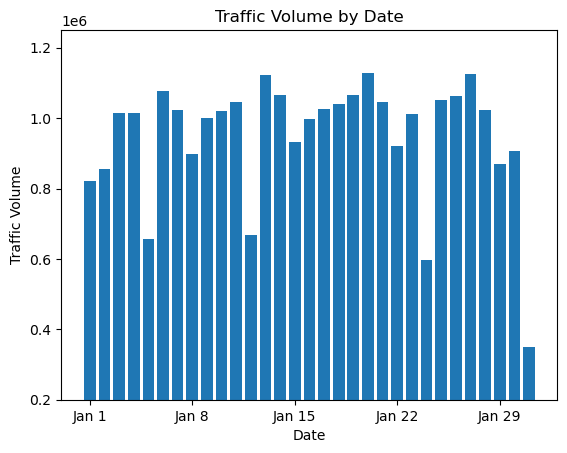

In [842]:
traffic_volumes_by_date = austin_df.groupby('day_record')['total_sum'].sum()
fig, ax = plt.subplots()

ax.bar(
    x=traffic_volumes_by_date.index,
    height=traffic_volumes_by_date.values
) 

ax.set_ylabel('Traffic Volume')
ax.set_title('Traffic Volume by Date')
ax.set_xlabel('Date')

label_list = range(1, 31, 7)
date_list = [f"Jan {num}" for num in label_list]

plt.xticks(label_list, date_list)
plt.ylim(200000, 1250000)

plt.show()

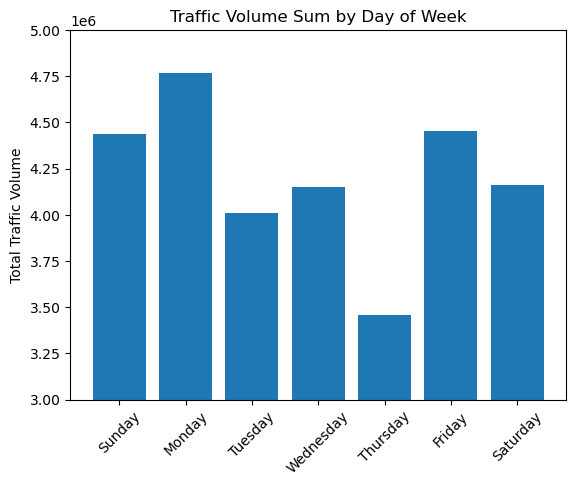

In [840]:
traffic_volumes_by_dow_groupby = austin_df.groupby('day_of_week')['total_sum']
dow_mapping = {
    1: "Sunday",
    2: "Monday",
    3: "Tuesday",
    4: "Wednesday",
    5: "Thursday",
    6: "Friday",
    7: "Saturday"
}

fig, ax = plt.subplots()
ax.bar(
    x=traffic_volumes_by_dow_groupby.sum().index,
    height=traffic_volumes_by_dow_groupby.sum().values
) 

ax.set_ylabel('Total Traffic Volume')
ax.set_title('Traffic Volume Sum by Day of Week')
ax.tick_params(axis='x', rotation=45)
plt.xticks(list(dow_mapping.keys()), list(dow_mapping.values()))
plt.ylim(3000000, 5000000)

plt.show()

In [844]:
traffic_volumes_per_hour_by_date = austin_df.groupby(['day_record', 'day_of_week'])[['hour_00', 'hour_01', 'hour_02', 'hour_03', 'hour_04',
       'hour_05', 'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'total_sum']].sum().reset_index()

# logic to classify weeks
first_sun = traffic_volumes_per_hour_by_date[traffic_volumes_per_hour_by_date['day_of_week'] == 1]['day_record'].min()
week_one = range(first_sun,first_sun+7)
max_day_record = traffic_volumes_per_hour_by_date['day_record'].max()

if first_sun == 1:
    week = 1
else:
    week = 0

week_dict = {}
week_list = []
for day in range(1, max_day_record+1):
    week_list.append(day)
    if len(week_list) == 7:
        week_dict[week] = np.array(week_list)
        week_list = []
        week += 1
    else:
        if day == max_day_record:
            week_dict[week] = np.array(week_list)

flattened_week_dict = [[{v: k} for v in vs] for k, vs in week_dict.items()]
final_arr = {}
for sub_arr in flattened_week_dict:
    for element in sub_arr:
        final_arr.update(element)

traffic_volumes_per_hour_by_date['week_no'] = [final_arr[day] for day in traffic_volumes_per_hour_by_date['day_record'] if day in final_arr.keys()]
traffic_volumes_per_hour_by_date.head()

,day_record,day_of_week,hour_00,hour_01,hour_02,hour_03,hour_04,hour_05,hour_06,hour_07,...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,total_sum,week_no
0,1,1,29292,32224,24494,16122,9594,8856,9672,12078,...,57452,54128,51896,43528,35248,30038,24316,17086,820704,1
1,2,2,11672,7836,7164,5734,6976,13554,23006,30946,...,61128,55648,52482,43172,35534,30252,23838,16318,854530,1
2,3,3,11590,7902,7600,6982,11016,28580,48296,58450,...,64076,63386,59138,47734,36326,30554,26058,17218,1014988,1
3,4,4,11870,9564,7870,7456,10988,28336,48612,61064,...,60140,60180,58860,48382,37356,30996,24552,16972,1013484,1
4,5,5,5670,4090,3670,3562,5794,15784,29568,40068,...,43720,41550,41202,31128,22650,18142,14146,9194,658008,1


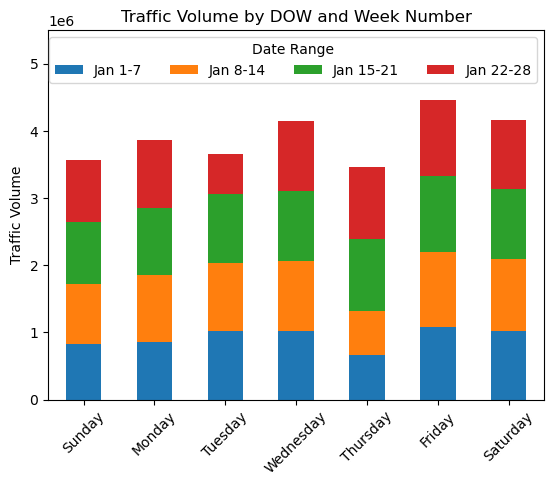

In [756]:
dow_week_no_groupby = traffic_volumes_per_hour_by_date.groupby(['week_no', 'day_of_week'])['total_sum'].sum()
df_pivot = dow_week_no_groupby.pivot(index='day_of_week', columns='week_no', values='total_sum')

df_pivot[[1,2,3,4]].plot(kind='bar', stacked=True)
plt.title('Traffic Volume by DOW and Week Number')
plt.ylabel('Traffic Volume')
plt.xlabel(None)
plt.xticks(
    range(0,7), 
    ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    title='Date Range', 
    handles=handles, 
    ncol=len(df_pivot),
    labels=['Jan 1-7', 'Jan 8-14', 'Jan 15-21', 'Jan 22-28']
)
plt.tick_params(axis='x', rotation=45)
plt.ylim(0, 5500000)

plt.show()

# Traffic volumes by hour

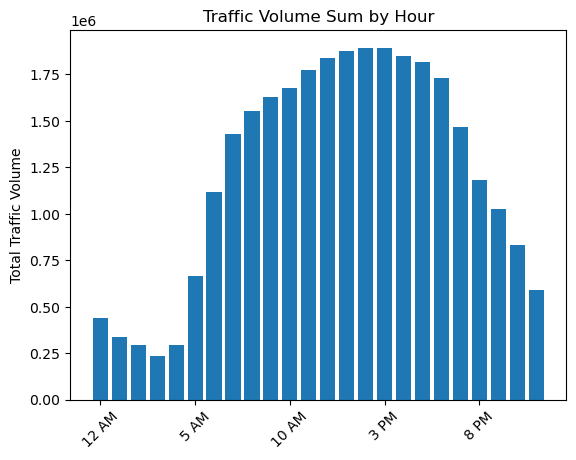

In [972]:
hour_vol = traffic_volumes_per_hour_by_date.iloc[:,2:26].sum(axis=0)
fig, ax = plt.subplots()

ax.bar(
    x=hour_vol.index,
    height=hour_vol.values
)

ax.set_ylabel('Total Traffic Volume')
ax.set_title('Traffic Volume Sum by Hour')
ax.tick_params(axis='x', rotation=45)

xtick_mapping = [datetime.strptime(str(time), "%H").strftime("%-I %p") for time in range(0,24)]
old_xticks = np.array(list(hour_vol.index))[range(0,24,5)]
new_xticks = np.array(xtick_mapping)[range(0,24,5)]

plt.xticks(old_xticks, new_xticks)
plt.show()

In [1012]:
weekends = traffic_volumes_per_hour_by_date[traffic_volumes_per_hour_by_date['day_of_week'].isin([1, 6])]
weekdays = traffic_volumes_per_hour_by_date[~traffic_volumes_per_hour_by_date['day_of_week'].isin([1, 6])]

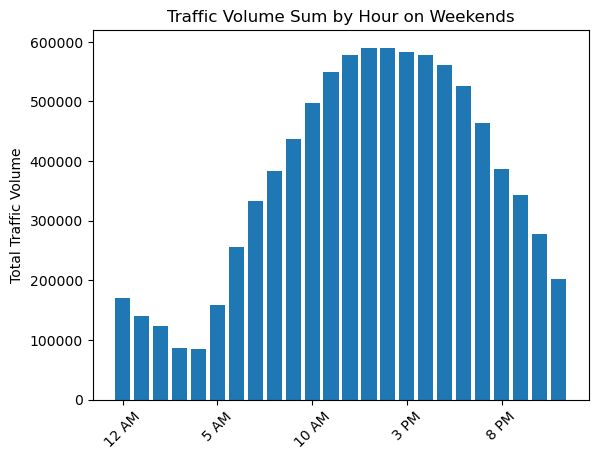

In [1020]:
hour_vol = weekends.iloc[:,2:26].sum(axis=0)

fig, ax = plt.subplots()

ax.bar(
    x=hour_vol.index,
    height=hour_vol.values
)

ax.set_ylabel('Total Traffic Volume')
ax.set_title('Traffic Volume Sum by Hour on Weekends')
ax.tick_params(axis='x', rotation=45)

xtick_mapping = [datetime.strptime(str(time), "%H").strftime("%-I %p") for time in range(0,24)]
old_xticks = np.array(list(hour_vol.index))[range(0,24,5)]
new_xticks = np.array(xtick_mapping)[range(0,24,5)]

plt.xticks(old_xticks, new_xticks)
plt.show()

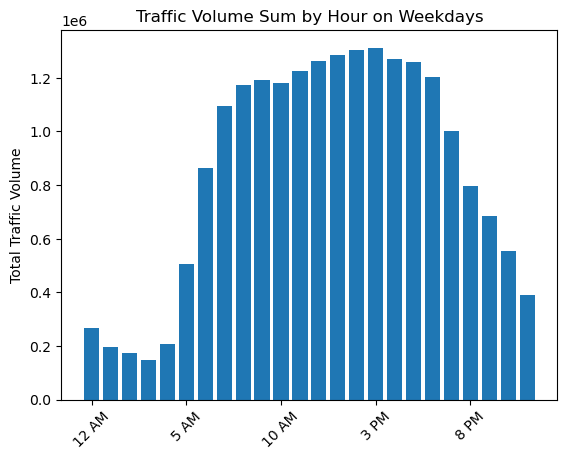

In [1026]:
hour_vol = weekdays.iloc[:,2:26].sum(axis=0)

fig, ax = plt.subplots()

ax.bar(
    x=hour_vol.index,
    height=hour_vol.values
)

ax.set_ylabel('Total Traffic Volume')
ax.set_title('Traffic Volume Sum by Hour on Weekdays')
ax.tick_params(axis='x', rotation=45)

xtick_mapping = [datetime.strptime(str(time), "%H").strftime("%-I %p") for time in range(0,24)]
old_xticks = np.array(list(hour_vol.index))[range(0,24,5)]
new_xticks = np.array(xtick_mapping)[range(0,24,5)]

plt.xticks(old_xticks, new_xticks)
plt.show()

# Comparing volumes on the weekend vs. weekdays

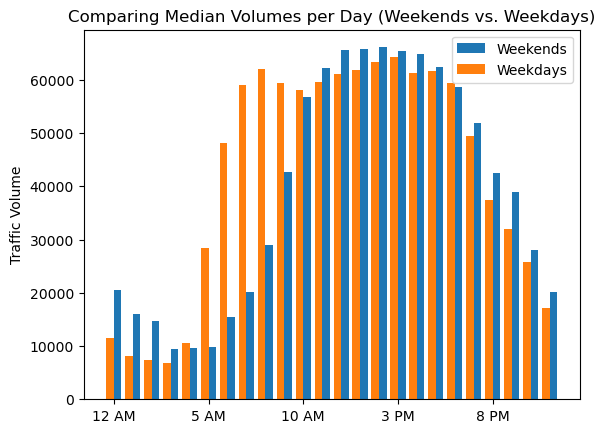

In [1126]:
weekday_vol_avg = weekdays.iloc[:,2:26].median(axis=0)
weekend_vol_avg = weekends.iloc[:,2:26].median(axis=0)

X_axis = np.arange(len(cols_to_transform))

plt.bar(X_axis + 0.2, weekend_vol_avg, 0.4, label = 'Weekends') 
plt.bar(X_axis - 0.2, weekday_vol_avg, 0.4, label = 'Weekdays') 
plt.title('Comparing Median Volumes per Day (Weekends vs. Weekdays)')
plt.ylabel('Traffic Volume')
plt.xticks([0, 5, 10, 15, 20], ['12 AM', '5 AM', '10 AM', '3 PM', '8 PM'])
plt.legend()
plt.show()